In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d sid321axn/gold-price-prediction-dataset

  0% 0.00/371k [00:00<?, ?B/s]
100% 371k/371k [00:00<00:00, 115MB/s]


In [ ]:
! unzip  '/content/gold-price-prediction-dataset.zip' -d '/content/gold-price'

Archive:  /content/gold-price-prediction-dataset.zip
  inflating: /content/gold-price/FINAL_USO.csv  


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import make_grid
import torch.utils.data as data
from torch.autograd import Variable
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cpu'

In [ ]:
df = pd.read_csv('/content/gold-price/FINAL_USO.csv')
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1718 non-null   object 
 1   Open           1718 non-null   float64
 2   High           1718 non-null   float64
 3   Low            1718 non-null   float64
 4   Close          1718 non-null   float64
 5   Adj Close      1718 non-null   float64
 6   Volume         1718 non-null   int64  
 7   SP_open        1718 non-null   float64
 8   SP_high        1718 non-null   float64
 9   SP_low         1718 non-null   float64
 10  SP_close       1718 non-null   float64
 11  SP_Ajclose     1718 non-null   float64
 12  SP_volume      1718 non-null   int64  
 13  DJ_open        1718 non-null   float64
 14  DJ_high        1718 non-null   float64
 15  DJ_low         1718 non-null   float64
 16  DJ_close       1718 non-null   float64
 17  DJ_Ajclose     1718 non-null   float64
 18  DJ_volum

In [ ]:
df2 = df[['Date', 'Close']]
df2.head(5)

,Date,Close
0,2011-12-15,152.330002
1,2011-12-16,155.229996
2,2011-12-19,154.869995
3,2011-12-20,156.979996
4,2011-12-21,157.160004


<Axes: xlabel='Date', ylabel='Close'>

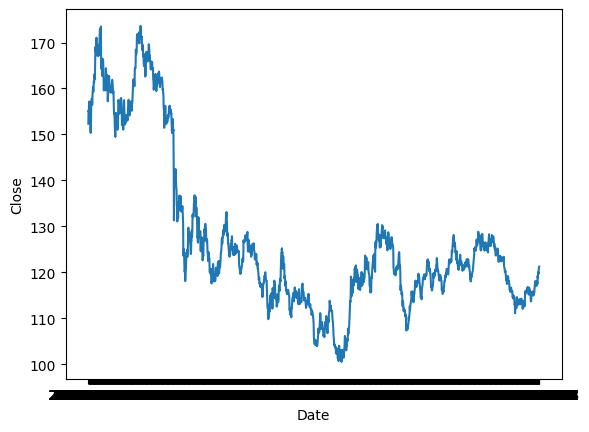

In [ ]:
sns.lineplot(data=df2, x="Date", y="Close")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mms = MinMaxScaler()

In [ ]:
timeseries = df2[['Close']]

In [ ]:
timeseries.head()

,Close
0,152.330002
1,155.229996
2,154.869995
3,156.979996
4,157.160004


In [ ]:
timeseries = timeseries.astype('float32')

In [ ]:
timeseries = mms.fit_transform(timeseries)

In [ ]:
train_size = int(len(timeseries)*0.8)
test_size = len(timeseries) - train_size
print(train_size)
print(test_size)
train, test = timeseries[:train_size], timeseries[train_size:]
print(len(train))
print(len(test))

1374
344
1374
344


In [ ]:
def My_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [ ]:
lookback = 4
X_train, y_train = My_dataset(train, lookback=lookback)
X_test, y_test = My_dataset(test, lookback=lookback)

In [ ]:
class GoldModel(nn.Module):
    def __init__(self):
        super(GoldModel, self).__init__()
        self.num_layers = 1
        self.hidden_size = 50

        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, _) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.linear(hn)
        return out

In [ ]:
model = GoldModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.1)
criterion = nn.MSELoss()

In [ ]:
batch_size = 32
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=batch_size,shuffle=True)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=batch_size,shuffle=True)

In [ ]:
! pip install torchinfo

In [ ]:
!pip install pytorch-ignite --quiet

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix, MeanSquaredError, RootMeanSquaredError
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "mse" : MeanSquaredError()}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics,device=device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device=device)

In [ ]:
training_history = {'mse':[]}
test_history = {'mse':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['mse']
    last_epoch.append(0)
    training_history['mse'].append(loss)
    if trainer.state.epoch % 100 == 0:
      print("Результат обучения - Эпоха: {}  ошибка: {:.7f}"
          .format(trainer.state.epoch,loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    loss = metrics['mse']
    test_history['mse'].append(loss)
    if trainer.state.epoch % 100 == 0:
      print("Результат валидации - Эпоха: {}  ошибка: {:.7f}"
          .format(trainer.state.epoch, loss))

In [ ]:
trainer.run(train_loader, max_epochs=2000)

Результат обучения - Эпоха: 100  ошибка: 0.0004617
Результат валидации - Эпоха: 100  ошибка: 0.0001366
Результат обучения - Эпоха: 200  ошибка: 0.0003537
Результат валидации - Эпоха: 200  ошибка: 0.0001110
Результат обучения - Эпоха: 300  ошибка: 0.0005403
Результат валидации - Эпоха: 300  ошибка: 0.0002681
Результат обучения - Эпоха: 400  ошибка: 0.0003798
Результат валидации - Эпоха: 400  ошибка: 0.0001215
Результат обучения - Эпоха: 500  ошибка: 0.0003454
Результат валидации - Эпоха: 500  ошибка: 0.0001128
Результат обучения - Эпоха: 600  ошибка: 0.0003391
Результат валидации - Эпоха: 600  ошибка: 0.0001058
Результат обучения - Эпоха: 700  ошибка: 0.0003501
Результат валидации - Эпоха: 700  ошибка: 0.0001215
Результат обучения - Эпоха: 800  ошибка: 0.0003362
Результат валидации - Эпоха: 800  ошибка: 0.0001022
Результат обучения - Эпоха: 900  ошибка: 0.0003807
Результат валидации - Эпоха: 900  ошибка: 0.0001348
Результат обучения - Эпоха: 1000  ошибка: 0.0003594
Результат валидации -

State:
	iteration: 86000
	epoch: 2000
	epoch_length: 43
	max_epochs: 2000
	output: 0.0002692399430088699
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

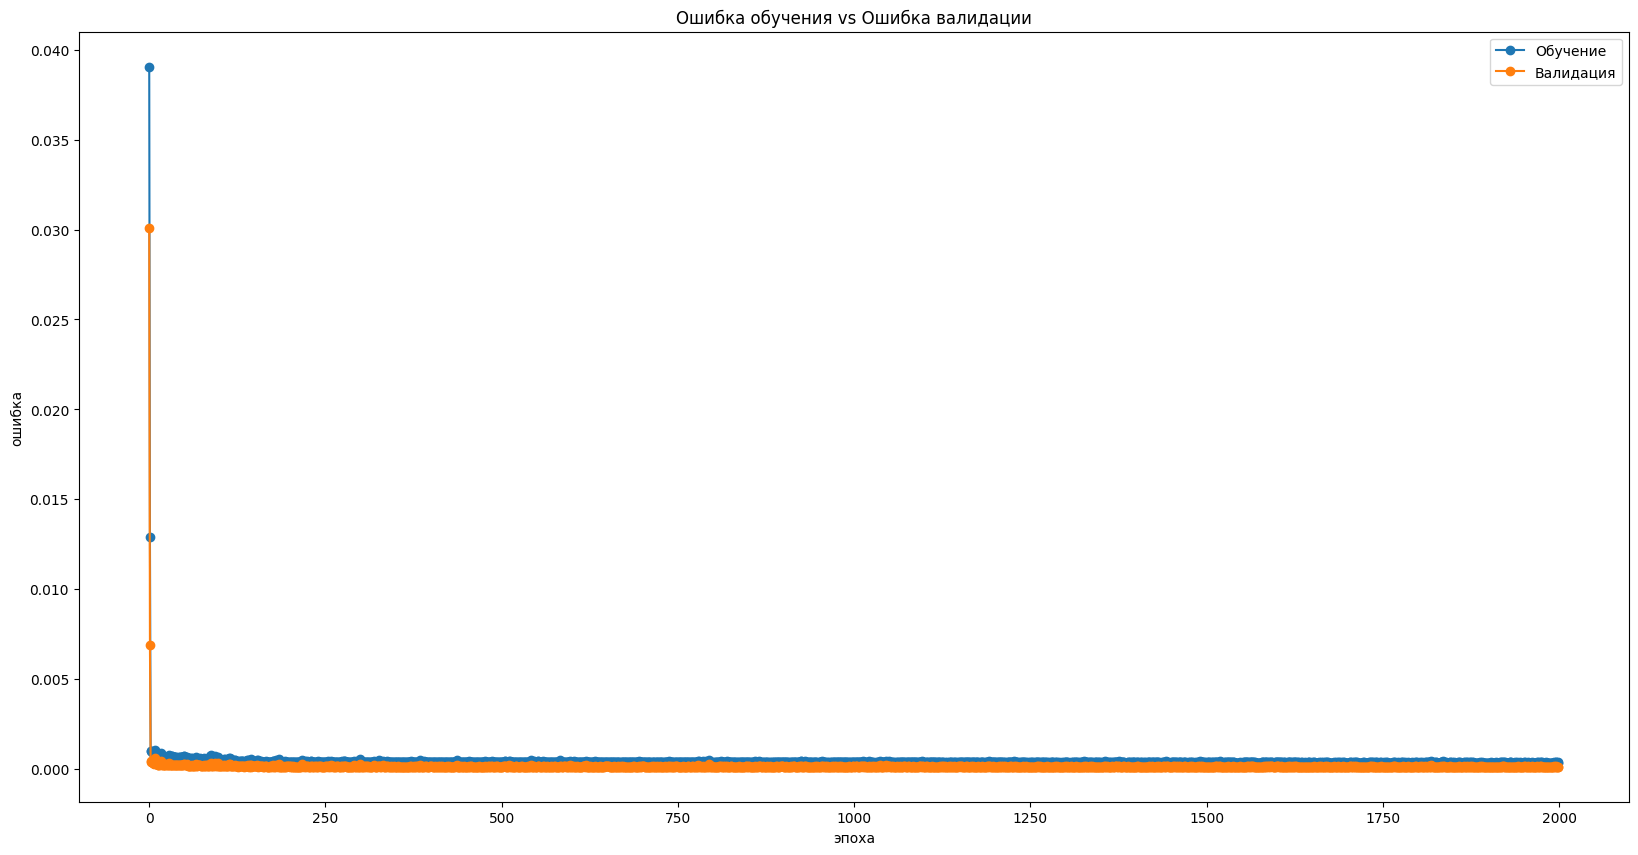

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['mse'],'-o')
plt.plot(test_history['mse'],'-o')
plt.xlabel('эпоха')
plt.ylabel('ошибка')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

In [ ]:
full_data_X = torch.cat((X_train, X_test),0)

In [ ]:
full_data_Y = torch.cat((y_train, y_test),0)

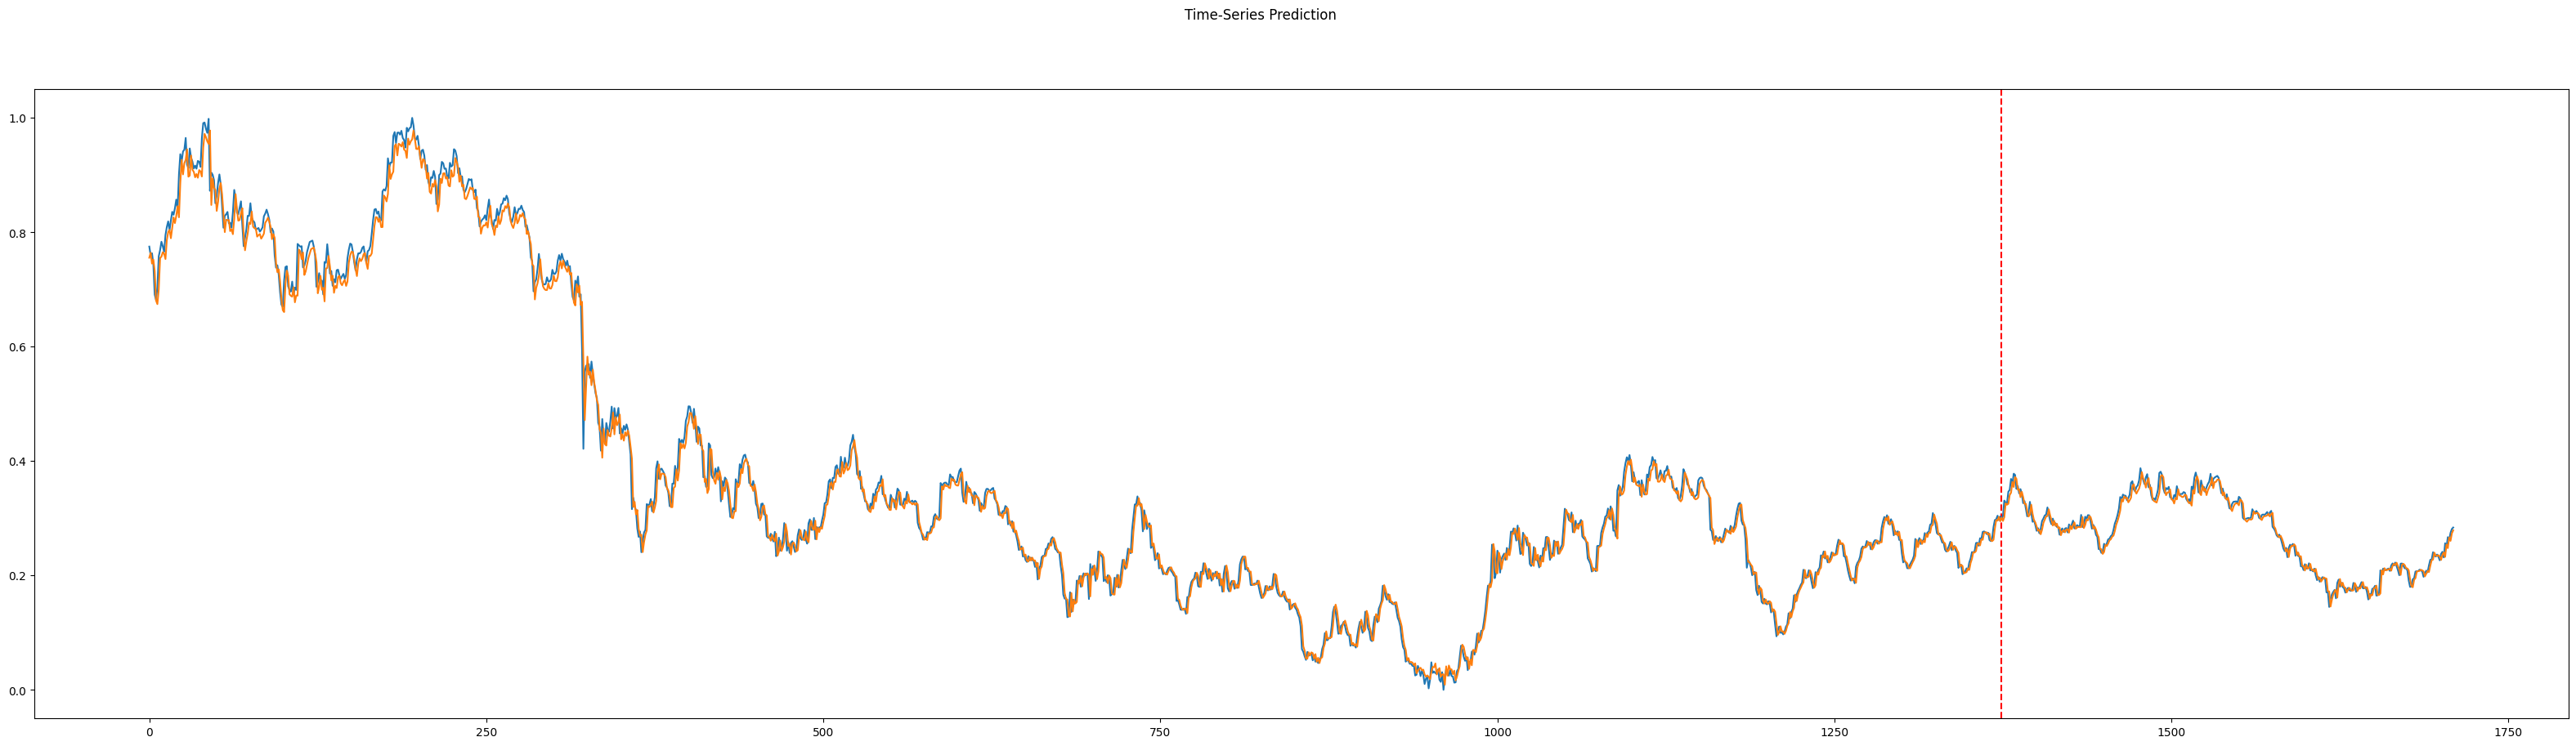

In [ ]:
train_predict = model(full_data_X)

data_predict = train_predict.data.numpy()
dataY_plot = full_data_Y.data.numpy()

data_predict = mms.inverse_transform(data_predict)
dataY_plot = mms.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')
plt.rcParams["figure.figsize"] = (40,15)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()